In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
from ta.momentum import rsi
import talib as ta

from utils import pre_adj_factor

# 数据收集与预处理
本项目的第一步是聚合A股股票及其历史信息。为简化模型，我们从5000多只中国股票中选择同花顺漂亮100作为子集。数据首先被聚合并归一化处理

## 同花顺100成分股
聚合成分股并根据缺失值比例筛选股票。

In [12]:
relation_path = r"C:\\Users\\hp\\work\\stock_relation_strat\\data\\stock_relation.csv"

# concept ticker用作挑选股票子集，sector ticker用作图关系
concept_ticker = "同花顺漂亮100"
sector_ticker = "申万二级行业"
relations = pd.read_csv(relation_path)

relations_concept = relations[relations['常规概念'].apply(lambda x: concept_ticker in str(x))]
stocks = relations_concept[["股票代码", "股票名称", sector_ticker]]
rename_dict = {"股票代码": "Symbol", "股票名称": "Name", sector_ticker: "Sector"}
stocks = stocks.rename(columns=rename_dict)
stocks['Symbol'] = stocks['Symbol'].apply(lambda x: str(x).split(".")[0])
stocks = stocks.set_index("Symbol")

stocks.head()

,Name,Sector
Symbol,,
000002,万科A,房地产开发
000063,中兴通讯,通信设备
000301,东方盛虹,炼化及贸易
000333,美的集团,白色家电
000338,潍柴动力,汽车零部件


# 历史行情数据
股票的历史行情数据将从本地整合，提取最近5年的数据。采用多级索引（Symbol 和 Date）来存储每只股票的历史行情。

特征包括：
 归一化收盘价、对数收益率以及1w, 2w, 1m, 2m的年化对数收益率（记为 AR）。对数收益率因其更接近正态分布且能处理较大年化收益而被采用。每日波动通过计算得出，收盘价也进行了归一化处理。

此外，计算了两个技术指标：

RSI：用于判断股票是否超买或超卖。
MACD：通过动量指标提供交易信号。
这些技术指标有助于交易模型更深入地理解当前价格信息。

In [85]:
data_path = r"D:\股票数据\stock_temporal"
rename_dict = {
    "交易日期": "Date",
    "收盘价": "Close"
    # "最高价": "High",
    # "最低价": "Low",
    # "开盘价": "Open",
    # "成交额(千元)": "Volume"
}
start_date = "2022/01/01"
end_date = "2025/04/01"

files = os.listdir(data_path)
file_paths = [os.path.join(data_path, file) for file in files if file.split(".")[0] in stocks.index]

values = []
for file_path in file_paths:
    df = pd.read_csv(file_path).rename(columns=rename_dict)
    values.append(df)

values = [
    pd.read_csv(file_path).rename(columns=rename_dict) for file_path in file_paths
]

for i in range(len(values)):
    values[i]['Date'] = pd.to_datetime(values[i]['Date'], format="%Y%m%d")
    values[i].sort_values(by='Date', ascending=True, inplace=True)

    # 对收盘价进行前复权，采用前复权收盘价作为目标
    values[i] = pre_adj_factor(values[i], "Close", "复权因子")
    values[i]['Close'] = values[i]['adj_close']

    values[i] = values[i][rename_dict.values()]
    values[i] = values[i][(values[i]['Date'] >= start_date) & (values[i]['Date'] <= end_date)]
    values[i].set_index('Date', inplace=True)

In [86]:
stocks.index[0], values[0].tail()

('000002',
             Close
 Date             
 2025-03-26   7.20
 2025-03-27   7.17
 2025-03-28   7.12
 2025-03-31   7.05
 2025-04-01   7.11)

In [87]:
# 获取所有DataFrame的日期索引的并集
all_dates = pd.Index([], name='Date')
for value in values:
    all_dates = all_dates.union(value.index)

# 将日期并集补齐到每个DataFrame的index中
for i in range(len(values)):
    values[i] = values[i].reindex(all_dates)

In [88]:
# 计算每个DataFrame空值行数占比，筛选出空值行数占比超过2%的索引
threshold = 0.02
to_remove = []
for i, df in enumerate(values):
    null_ratio = df.isnull().any(axis=1).mean()
    min_price = df['Close'].min()
    if null_ratio > threshold or min_price <= 2:
        to_remove.append(i)
    
print("要移除的股票名称：", stocks.iloc[to_remove]["Name"].tolist())

# 移除values和stocks中对应的项
if to_remove:
    # 先移除values
    values = [df for i, df in enumerate(values) if i not in to_remove]
    # 再移除stocks
    stocks = stocks.drop(stocks.index[to_remove])

# 检查结果
print(f"已移除 {len(to_remove)} 个空值行数占比超过2%的股票")
stocks.head()

要移除的股票名称： []
已移除 0 个空值行数占比超过2%的股票


,Name,Sector
Symbol,,
000002,万科A,房地产开发
000063,中兴通讯,通信设备
000301,东方盛虹,炼化及贸易
000333,美的集团,白色家电
000338,潍柴动力,汽车零部件


In [89]:
# 填补空值，先用前值填充，后值填充对应的是start date后上市的公司
values = [value.fillna(method="ffill").fillna(method="bfill") for value in values]

In [90]:
def assert_all_symbols_same_dates(values):
    date_lens = [df.shape[0] for df in values]
    assert len(set(date_lens)) == 1, f"Not all symbols have the same number of dates: {date_lens}"
    print("所有 symbol 的日期长度一致：", date_lens[0])

In [91]:
assert_all_symbols_same_dates(values)

所有 symbol 的日期长度一致： 784


In [92]:
# 特征工程 简单版
# 归一化在后面进行
TRADE_DAYS_YEAR = 252
fast, slow = 5, 20

for idx, stock_values in enumerate(values):
    # 日度收益
    stock_values['daily_logret'] = np.log(stock_values['Close']).diff()
    
    # Assuming 5 trading days per week and 21 trading days per month
    for N in [5, 10, 20, 40, 60, 120]:
        stock_values[f"ALR{N}"] = stock_values["daily_logret"].rolling(window=N).sum() * (TRADE_DAYS_YEAR / N)

    # 年化波动率
    for N in [5, 10, 20, 40, 60]:
        # Annualize the volatility: std(N-day Return) * sqrt(TRADE_DAYS_YEAR/N)
        stock_values[f"VOL{N}"] = stock_values['daily_logret'].rolling(window=N).std() * np.sqrt(TRADE_DAYS_YEAR)
    # MACD
    # macd, hist, signal 分别代表：
    # macd: 快线与慢线的差值（MACD线）
    # signal: macd的信号线（通常是macd的9日EMA）
    # hist: macd与signal的差值（柱状图，反映多空能量）
    macd, signal, hist = ta.MACD(stock_values['Close'], fastperiod=fast, slowperiod=slow, signalperiod=9)
    stock_values['macd'] = macd
    stock_values['macd_signal'] = signal
    
    # stock_values.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)
		
values = pd.concat(values, keys=stocks.index)
values.iloc[110:125]

Close  daily_logret      ALR5     ALR10  \
Symbol Date                                                               
000002 2022-06-22 00:00:00  16.389772     -0.015185 -0.110044  1.068910   
       2022-06-23 00:00:00  16.631588      0.014646  1.069754  1.024757   
       2022-06-24 00:00:00  16.425596     -0.012463  0.524861  0.668326   
       2022-06-27 00:00:00  16.577851      0.009227 -0.190240  1.457215   
       2022-06-28 00:00:00  16.524114     -0.003247 -0.353877  0.974707   
       2022-06-29 00:00:00  17.580941      0.061995  3.535961  1.712958   
       2022-06-30 00:00:00  18.360127      0.043366  4.983427  3.026590   
       2022-07-01 00:00:00  18.270565     -0.004890  5.365102  2.944981   
       2022-07-04 00:00:00  18.100398     -0.009357  4.428467  2.119113   
       2022-07-05 00:00:00  17.948144     -0.008447  4.166362  1.906242   
       2022-07-06 00:00:00  17.437642     -0.028855 -0.412483  1.561739   
       2022-07-07 00:00:00  17.186870     -0.014486 -3.328193  0.827617   
       2022-07-08 00:00:00  17.267475      0.004679 -2.845917  1.259592   
       2022-07-11 00:00:00  16.998791     -0.015682 -3.164704  0.631882   
       2022-07-12 00:00:00  17.043571      0.002631 -2.606365  0.779998   

                               ALR20     ALR40     ALR60    ALR120      VOL5  \
Symbol Date                                                                    
000002 2022-06-22 00:00:00  0.124548 -0.335185  0.168585       NaN  0.232414   
       2022-06-23 00:00:00  0.239746 -0.407229  0.151990       NaN  0.238908   
       2022-06-24 00:00:00 -0.034304 -0.166111  0.201714       NaN  0.266459   
       2022-06-27 00:00:00  0.254415 -0.151328  0.257319       NaN  0.207388   
       2022-06-28 00:00:00  0.437761  0.075573  0.157721       NaN  0.207924   
       2022-06-29 00:00:00  1.225966  0.305774  0.487207       NaN  0.457644   
       2022-06-30 00:00:00  1.722951  0.353955  0.323564       NaN  0.503223   
       2022-07-01 00:00:00  1.781709  0.306915  0.265575       NaN  0.474723   
       2022-07-04 00:00:00  1.966220  0.560369 -0.092492       NaN  0.520592   
       2022-07-05 00:00:00  1.758171  0.510560 -0.240298       NaN  0.534810   
       2022-07-06 00:00:00  1.315324  0.301556 -0.299681 -0.107231  0.426155   
       2022-07-07 00:00:00  0.926187  0.244333 -0.475433 -0.206211  0.149160   
       2022-07-08 00:00:00  0.963959  0.439792 -0.306583 -0.184448  0.192072   
       2022-07-11 00:00:00  1.044548  0.103747 -0.255404 -0.299553  0.193300   
       2022-07-12 00:00:00  0.877353  0.049855 -0.312514 -0.319772  0.222011   

                               VOL10     VOL20     VOL40     VOL60      macd  \
Symbol Date                                                                    
000002 2022-06-22 00:00:00  0.277976  0.240004  0.340546  0.427107  0.143959   
       2022-06-23 00:00:00  0.275962  0.244684  0.335774  0.426475  0.181803   
       2022-06-24 00:00:00  0.288246  0.247025  0.312535  0.424206  0.149813   
       2022-06-27 00:00:00  0.253826  0.243721  0.312956  0.424432  0.162012   
       2022-06-28 00:00:00  0.250634  0.234112  0.296847  0.422570  0.151433   
       2022-06-29 00:00:00  0.362966  0.316704  0.329254  0.439280  0.391869   
       2022-06-30 00:00:00  0.393446  0.344845  0.334943  0.415433  0.709975   
       2022-07-01 00:00:00  0.396915  0.342293  0.335298  0.415313  0.857985   
       2022-07-04 00:00:00  0.403834  0.328325  0.310173  0.385364  0.879507   
       2022-07-05 00:00:00  0.410923  0.333343  0.311261  0.381519  0.828317   
       2022-07-06 00:00:00  0.437017  0.356821  0.320677  0.384784  0.649597   
       2022-07-07 00:00:00  0.445630  0.360806  0.322689  0.381062  0.461467   
       2022-07-08 00:00:00  0.436892  0.360744  0.315024  0.374759  0.352535   
       2022-07-11 00:00:00  0.447898  0.355326  0.303990  0.371879  0.211665   
       2022-07-12 00:00:00  0.446754  0.352615  0.302787  0.370226  0.130638   

                            macd_s

In [93]:
values.columns

Index(['Close', 'daily_logret', 'ALR5', 'ALR10', 'ALR20', 'ALR40', 'ALR60',
       'ALR120', 'VOL5', 'VOL10', 'VOL20', 'VOL40', 'VOL60', 'macd',
       'macd_signal'],
      dtype='object')

In [94]:
# 统计values中每一列的空值数量
null_counts = values.isnull().sum()
print("各列空值数量：")
print(null_counts)

# 统计所有行中至少有一个空值的行数
rows_with_null = values.isnull().any(axis=1).sum()
print(f"包含至少一个空值的行数: {rows_with_null}")

各列空值数量：
Close               0
daily_logret       99
ALR5              495
ALR10             990
ALR20            1980
ALR40            3960
ALR60            5940
ALR120          11880
VOL5              495
VOL10             990
VOL20            1980
VOL40            3960
VOL60            5940
macd             2673
macd_signal      2673
dtype: int64
包含至少一个空值的行数: 11880


In [95]:
values.dropna(inplace=True)

In [96]:
date_counts = values.reset_index().groupby('Symbol')['Date'].nunique()
print("每个 symbol 的日期数：")
print(date_counts)
print("是否全部一致：", date_counts.nunique() == 1)
if date_counts.nunique() != 1:
    inconsistent_symbols = date_counts[date_counts != date_counts.mode()[0]].index.tolist()
    print("日期数不一致的标的：", inconsistent_symbols)

每个 symbol 的日期数：
Symbol
000002    664
000063    664
000301    664
000333    664
000338    664
         ... 
603993    664
688036    664
688111    664
688599    664
688981    664
Name: Date, Length: 99, dtype: int64
是否全部一致： True


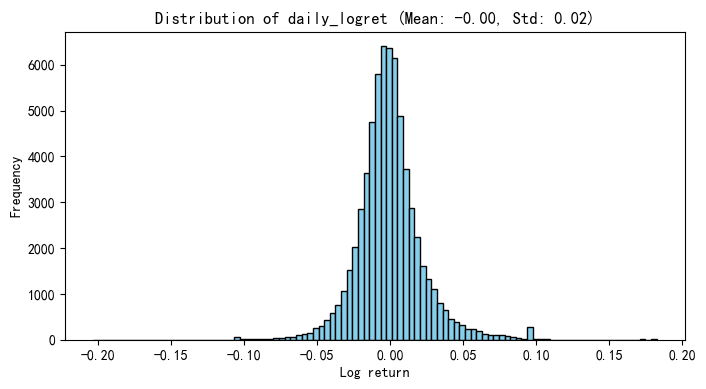

In [98]:
plt.figure(figsize=(8, 4))

column = "daily_logret"
plt.hist(values[column], bins=100, color="skyblue", edgecolor="black")
plt.title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
plt.xlabel("Log return")
plt.ylabel("Frequency")
plt.show()

In [99]:
min_idx = values[column].idxmin()
min_value = values.loc[min_idx, column]
stock_code, date = min_idx
stock_name = stocks.loc[stock_code, "Name"]
print(f"Daily Return最小的股票: {stock_name} ({stock_code})，时间: {date.date()}，最小值: {min_value:.4f}")

max_idx = values[column].idxmax()
max_value = values.loc[max_idx, column]
stock_code, date = max_idx
stock_name = stocks.loc[stock_code, "Name"]
print(f"Daily Return最大的股票: {stock_name} ({stock_code})，时间: {date.date()}，最大值: {max_value:.4f}")

Daily Return最小的股票: 爱美客 (300896)，时间: 2024-10-09，最小值: -0.2033
Daily Return最大的股票: 智飞生物 (300122)，时间: 2024-10-08，最大值: 0.1824


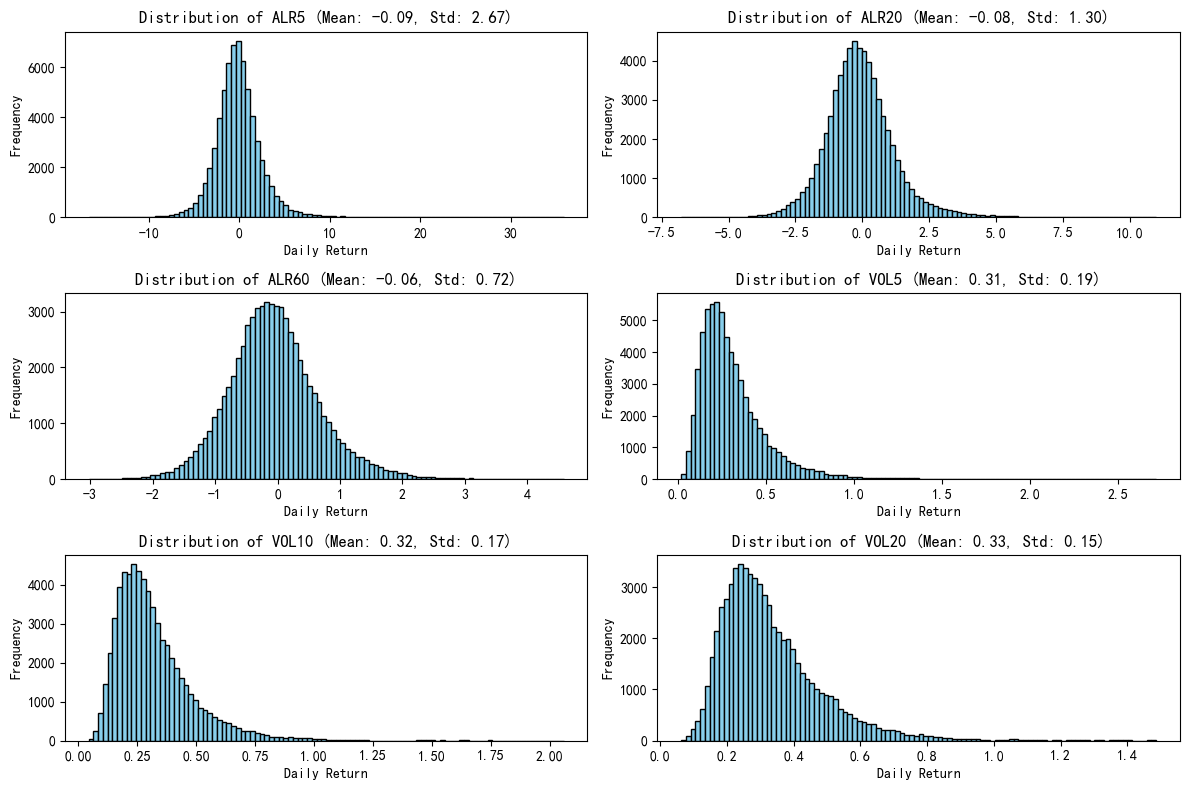

In [102]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

for idx, column in enumerate(["ALR5", "ALR20", "ALR60", "VOL5", "VOL10", "VOL20"]):
	ax = axs[idx // 2, idx % 2]
	ax.hist(values[column], bins=100, color="skyblue", edgecolor="black")
	ax.set_title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
	ax.set_xlabel("Daily Return")
	ax.set_ylabel("Frequency")
	
plt.tight_layout()
plt.show()

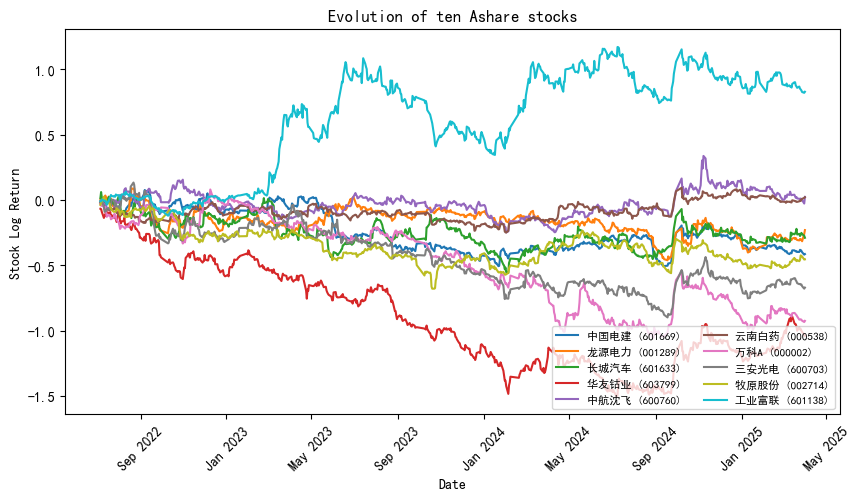

In [103]:
plt.figure(figsize=(10, 5))

for stock in np.random.choice(stocks.index, size=10, replace=False):
	plt.plot(values.loc[stock].index, np.cumsum(values.loc[stock]["daily_logret"]), label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of ten Ashare stocks")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Stock Log Return')
plt.legend(ncol=2, loc="lower right", prop={'size': 8})
plt.show()

In [105]:
os.makedirs("data/Ashare100/raw", exist_ok=True)
values.to_csv("data/Ashare100/raw/values.csv")
stocks.to_csv("data/Ashare100/raw/stocks.csv")